<a href="https://colab.research.google.com/github/kiatkai96/Data-Science-Projects/blob/main/Full_Codes_for_gradient_boosting_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from numpy import argmax
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from pickle import dump
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Read the data from csv file

In [2]:
df = pd.read_csv("/content/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## The data is highly imbalanced with less than 1% of positive labels

Summary


*   The transaction amount is relatively small. The mean of all the mounts made is approximately USD 88.
*   There are no "Null" values, so we don't have to work on ways to replace values.
*   Most of the transactions were Non-Fraud (99.83%) of the time, while Fraud transactions occurs (017%) of the time in the dataframe.


Feature Technicalities:


*   PCA Transformation: The description of the data says that all the features went through a PCA transformation (Dimensionality Reduction technique) (Except for time and amount).
*   Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled. (In this case, all the V features have been scaled or at least that is what we are assuming the people that develop the dataset did.)









In [3]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Correlation Plot
- From the correlation plot below, there does not seem to have any high collinearity with the features, thus we won't drop any features.

(29.5, -0.5)

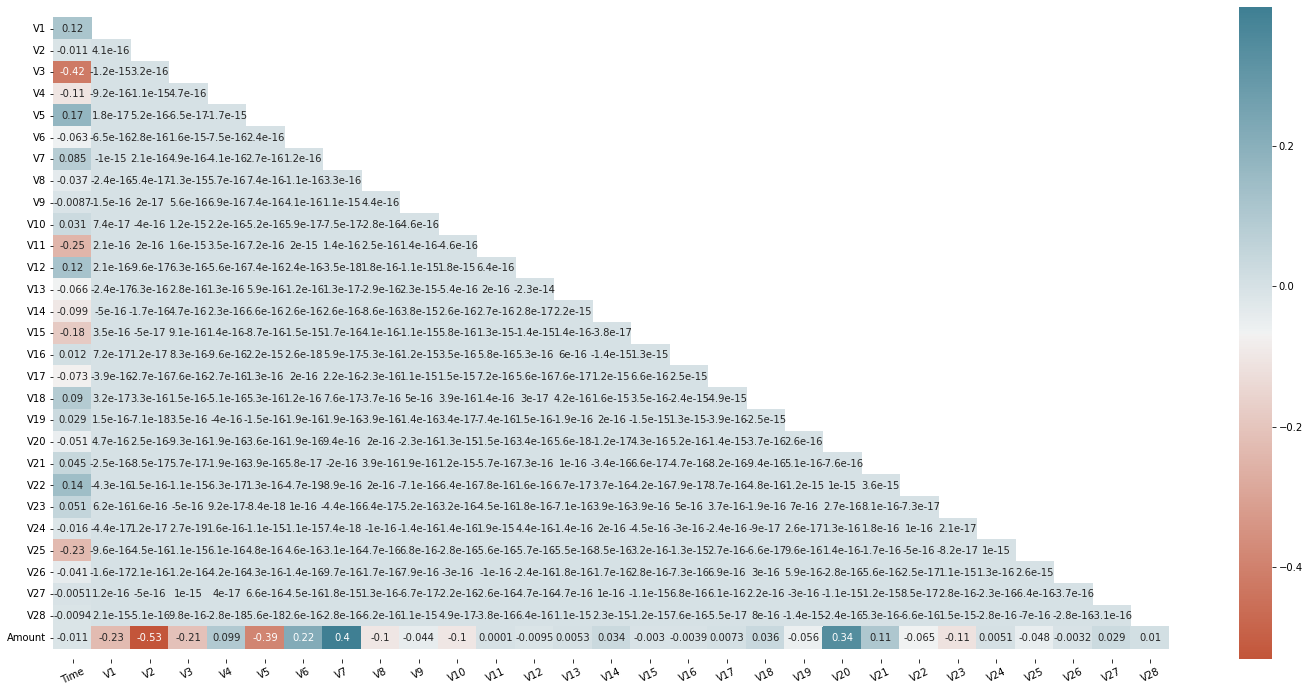

In [ ]:
fig, ax = plt.subplots(figsize=(25,12))
mask = np.triu(df.drop('Class', axis = 1).corr())
mask = mask[1:, :-1]
corr = df.drop('Class', axis=1).corr().iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap=sns.diverging_palette(20,220, n=256))
plt.xticks(rotation=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Encode the categorical variables

In [4]:
# # Replace Nan with 0's
# df.fillna(0, inplace=True)

# # Label encoders categorical variables
# LE = LabelEncoder()
y = pd.DataFrame(df['Class'])
X = df.loc[:, df.columns != 'Class']

## Stratified Train-Test Splits
- 75% training set, 25% test set
- Labels are split according to the proportion of examples in each class that is presented in the provided y array

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y['Class'], test_size=0.25, random_state=1, stratify=y['Class'])

print(Counter(y_train))
print(Counter(y_test))

Counter({0: 213236, 1: 369})
Counter({0: 71079, 1: 123})


## GridSearch with GradientBoostingClassifier

In [6]:
model = GradientBoostingClassifier(random_state=10)

# Stratified KFold to ensure class samples are splitted correctly
strat_kfold_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=10)

# Define Grid
parameters = {
    "learning_rate": [0.075, 0.06],
    # "min_samples_split": np.linspace(0.1, 0.5, 5),
    # "min_samples_leaf": np.linspace(0.1, 0.5, 5),
    "max_depth":[5,6],
    "max_features":["sqrt"],
    "n_estimators":[10,12,15]
    }

# Define evaluation procedure
scoring = {'AUC': 'roc_auc', 'F1': 'f1', 'F1 Macro': 'f1_macro', 'Recall': 'recall'}
grid = GridSearchCV(estimator = model, param_grid = parameters, n_jobs = -1, 
                          cv = strat_kfold_cv, scoring = scoring, refit = 'F1 Macro', verbose=2)

# Cross validation performed within the training set
grid_result = grid.fit(X_train, y_train)

# Print best F1 Macro Score
print(f"Best score (F1 Macro): {grid_result.best_score_} with param: {grid.best_params_}")

# Print Best estimator
print('\n The best estimator across all searched params:\n', grid_result.best_estimator_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best score (F1 Macro): 0.8801384759653873 with param: {'learning_rate': 0.075, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}

 The best estimator across all searched params:
 GradientBoostingClassifier(learning_rate=0.075, max_depth=5,
                           max_features='sqrt', n_estimators=10,
                           random_state=10)


In [ ]:
# Print Results
results = pd.DataFrame(grid_result.cv_results_)
results[["params","mean_test_F1 Macro","rank_test_F1 Macro"]]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_max_features,param_n_estimators,param_subsample,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_test_F1 Macro,split1_test_F1 Macro,split2_test_F1 Macro,split3_test_F1 Macro,mean_test_F1 Macro,std_test_F1 Macro,rank_test_F1 Macro,split0_test_Recall,split1_test_Recall,split2_test_Recall,split3_test_Recall,mean_test_Recall,std_test_Recall,rank_test_Recall
0,3.127256,0.102293,0.151616,0.009761,0.01,deviance,3,log2,10,0.5,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.894133,0.925926,0.948637,0.943876,0.928143,0.021384,19,0.000000,0.213592,0.021505,0.141414,0.094128,0.087524,99,0.499564,0.606417,0.510326,0.570309,0.546654,0.043784,99,0.000000,0.119565,0.010870,0.076087,0.051630,0.048838,99
1,4.403544,0.052129,0.156602,0.006897,0.01,deviance,3,log2,10,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.899011,0.963889,0.941840,0.918141,0.930720,0.024431,18,0.000000,0.103093,0.042553,0.138614,0.071065,0.053507,101,0.499564,0.551139,0.520855,0.568899,0.535114,0.026764,101,0.000000,0.054348,0.021739,0.076087,0.038043,0.029267,100
2,4.854656,0.031044,0.154106,0.009980,0.01,deviance,3,log2,10,0.9,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.892796,0.964197,0.942495,0.926992,0.931620,0.026020,17,0.000000,0.021505,0.063158,0.178218,0.065720,0.068805,103,0.499564,0.510326,0.531162,0.588720,0.532443,0.034420,103,0.000000,0.010870,0.032609,0.097826,0.035326,0.037946,102
3,5.228896,0.032770,0.146128,0.001771,0.01,deviance,3,log2,10,1.0,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.916268,0.965615,0.964072,0.915686,0.940410,0.024440,12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116,0.499560,0.499569,0.499569,0.499569,0.499567,0.000004,116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116
4,3.664028,0.035463,0.146940,0.002693,0.01,deviance,3,sqrt,10,0.5,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.905291,0.936795,0.915336,0.906701,0.916031,0.012590,32,0.000000,0.042553,0.000000,0.021505,0.016015,0.017659,115,0.499564,0.520855,0.499569,0.510326,0.507579,0.008835,115,0.000000,0.021739,0.000000,0.010870,0.008152,0.009013,115
5,5.388440,0.038429,0.149385,0.007817,0.01,deviance,3,sqrt,10,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.913482,0.927754,0.923092,0.911895,0.919056,0.006601,28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116,0.499560,0.499569,0.499569,0.499569,0.499567,0.000004,116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116
6,5.947083,0.017121,0.149648,0.005945,0.01,deviance,3,sqrt,10,0.9,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.913446,0.928694,0.923073,0.911891,0.919276,0.006922,27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116,0.499560,0.499569,0.499569,0.499569,0.499567,0.000004,116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116
7,6.348166,0.004340,0.145050,0.001486,0.01,deviance,3,sqrt,10,1.0,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.911641,0.927049,0.923174,0.907059,0.917231,0.008161,31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116,0.499564,0.499569,0.499564,0.499569,0.499567,0.000002,119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116
8,4.764502,0.026316,0.154869,0.004097,0.01,deviance,5,log2,10,0.5,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.917493,0.963326,0.918308,0.932096,0.932806,0.018552,16,0.082474,0.021053,0.083333,0.041667,0.057132,0.026784,106,0.540820,0.510091,0.541254,0.520402,0.528142,0.013402,106,0.043011,0.010870,0.043478,0.021739,0.029774,0.014009,106
9,7.105401,0.082547,0.153614,0.003262,0.01,deviance,5,log2,10,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.919692,0.943076,0.933282,0.914893,0.927736,0.011132,20,0.000000,0.101010,0.138614,0.000000,0.059906,0.0613

## Fit models with best parameters

In [7]:
tuned_model = GradientBoostingClassifier(learning_rate=0.075, max_depth=5,
                           max_features='sqrt', n_estimators=10,
                           random_state=10)
tuned_model.fit(X_train, y_train)

# Predict the test set
y_pred = tuned_model.predict(X_test)

In [8]:
## Test set scores ##
# F1 score 
print(f"F1 score: {f1_score(y_test, y_pred)}")
# F1 Macro score 
print(f"F1 Macro score: {f1_score(y_test, y_pred, average = 'macro')}")
# Auc Score
print(f"Auc score: {roc_auc_score(y_test, y_pred)}")
# Accuracy Score
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
# Recall score
print(f"recall score: {recall_score(y_test, y_pred)}")

F1 score: 0.8132780082987551
F1 Macro score: 0.9064807351201647
Auc score: 0.8982332952101733
Accuracy score: 0.9993679952810315
recall score: 0.7967479674796748


## Confusion Matrix

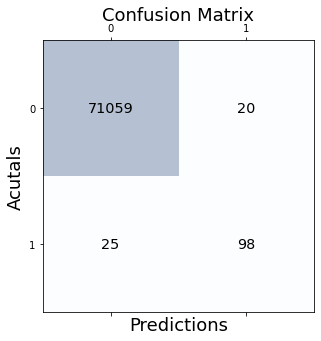

In [9]:
conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i,j], va='center', ha='center', size='x-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Acutals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Check back the predicted labels in the original data set

In [ ]:
sub = pd.DataFrame(data=X_test)
sub['pred'] = y_pred
sub['Label'] = y_test

sub[sub.pred == 1]

## Feature Importance

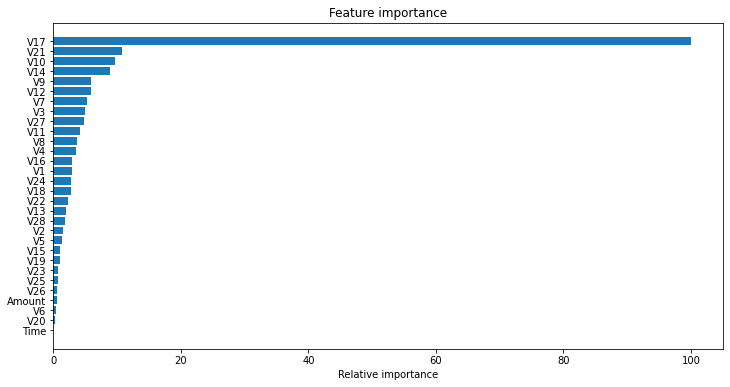

In [11]:
# Feature importance
importance = tuned_model.feature_importances_
feature_importance = 100 * (importance/importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.figure(figsize=(12,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.title("Feature importance")
plt.xlabel("Relative importance")
plt.yticks(pos, X.keys()[sorted_idx])
plt.show()